# Time-Series Classification: CNN1D

## Import libraries


In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from keras.models import load_model
import keras_visualizer
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.10.0


## Set seed for reproducibility


In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Data Preprocessing

### Load Data

In [3]:
data_x = np.load('Dataset/x_train.npy')
data_y = np.load('Dataset/y_train.npy')

In [4]:
training_labels = {
    'Wish': 0,
    'Another': 1,
    'Comfortably': 2,
    'Money': 3,
    'Breathe': 4,
    'Time': 5,
    'Brain' : 6,
    'Echoes' : 7,
    'Wearing' : 8,
    'Sorrow' : 9,
    'Hey' : 10,
    'Shine' : 11
}

In [5]:
class_weights = {
    0: 5.953431372549019,
    1: 1.6456639566395663,
    2: 0.7496913580246913,
    3: 0.5312773403324584,
    4: 3.264784946236559,
    5: 1.3229847494553377,
    6: 0.6466986155484558,
    7: 2.9767156862745097,
    8: 1.6868055555555554,
    9: 0.2605105105105105,
    10: 2.628787878787879,
    11: 3.968954248366013,
}

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, random_state=seed, stratify=data_y)

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1943, 36, 6), (486, 36, 6), (1943,), (486,))

In [8]:
y_test_classes = y_test

In [9]:
y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)

y_train.shape, y_test.shape

((1943, 12), (486, 12))

In [28]:
input_shape = X_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 32
epochs = 200

## Model

In [11]:
modelNormal = load_model('Autoencoder070')

Metal device set to: Apple M1 Pro


2022-12-14 10:29:43.597843: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-14 10:29:43.597975: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


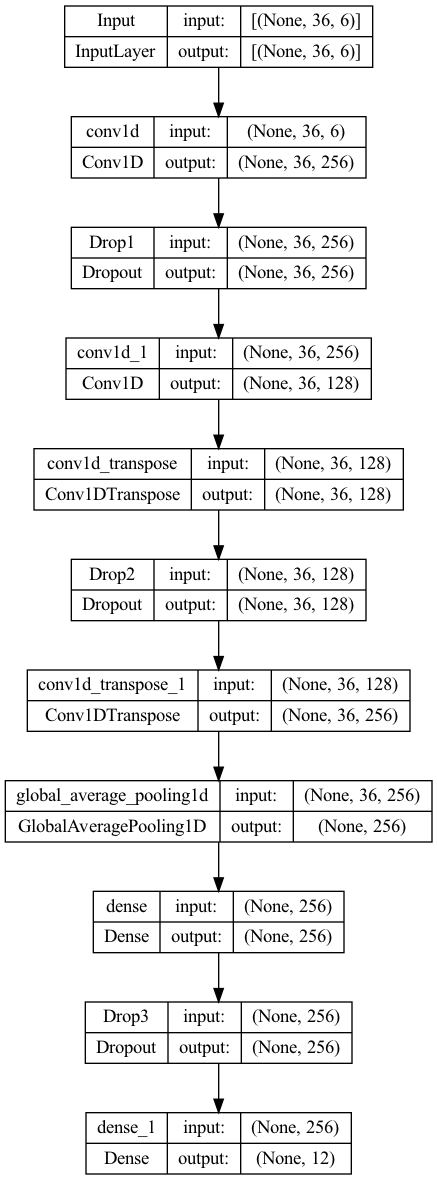

In [12]:
tfk.utils.plot_model(modelNormal, show_shapes=True, expand_nested=True)

In [132]:
modelWeighted = load_model('1DCNNWeights')

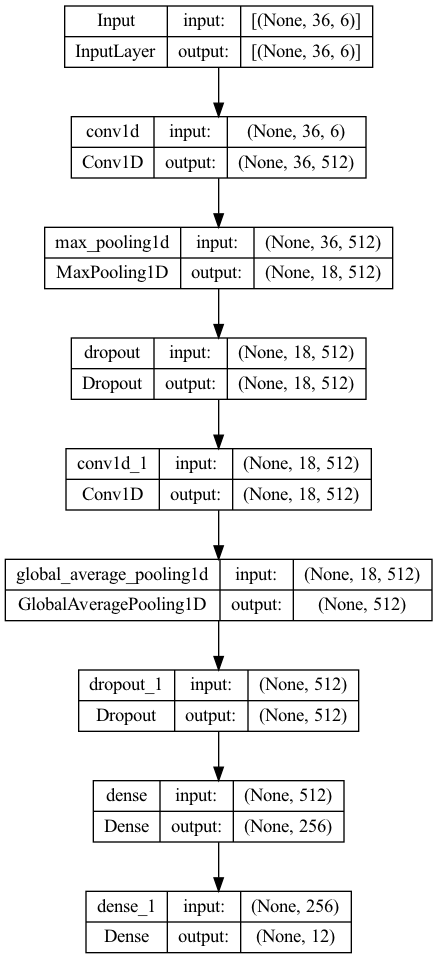

In [133]:
tfk.utils.plot_model(modelWeighted, show_shapes=True, expand_nested=True)

In [134]:
class WeightedAverageLayer(tf.keras.layers.Layer):
    def __init__(self, w1, w2, **kwargs):
        super(WeightedAverageLayer, self).__init__(**kwargs)
        self.w1 = w1
        self.w2 = w2

    def call(self, inputs):
        return self.w1 * inputs[0] + self.w2 * inputs[1]

In [135]:
models = [modelNormal, modelWeighted]
model_input = tf.keras.Input(shape=input_shape)
model_outputs = [model(model_input) for model in models]

In [156]:
#ensemble_output = tf.keras.layers.Average()(model_outputs)
#ensemble_output = tf.keras.layers.Maximum()(model_outputs)

ensemble_output = WeightedAverageLayer(0.95, 0.05)(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

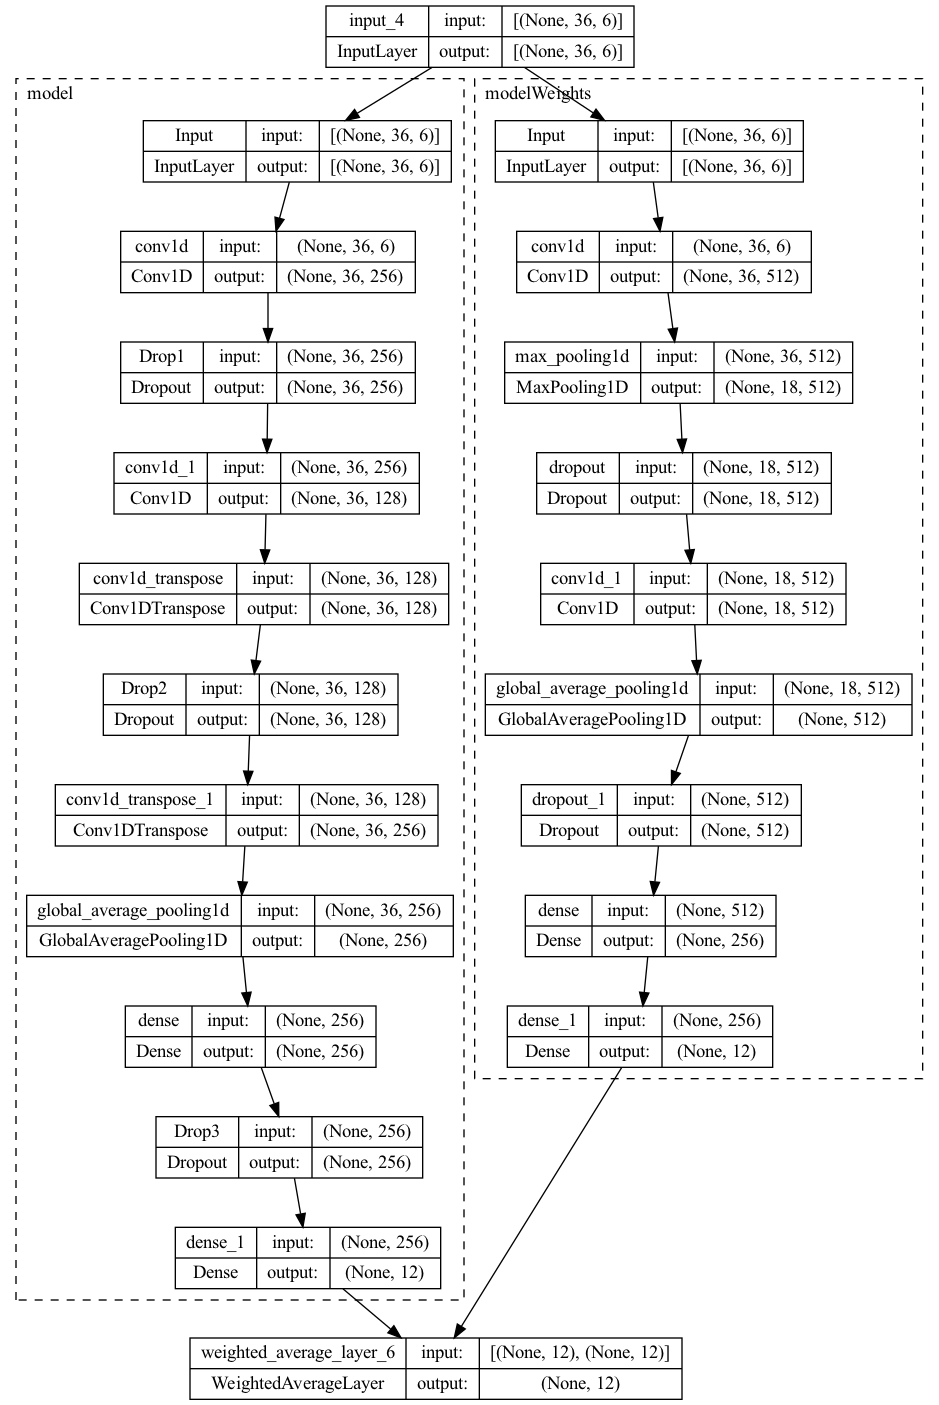

In [157]:
tfk.utils.plot_model(ensemble_model, show_shapes=True, expand_nested=True)

In [158]:
# Compile the model
ensemble_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

## Training

In [159]:
# Train the model
history = ensemble_model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split = 0.1,
    class_weight=class_weights,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200


2022-12-14 11:34:41.714307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - ETA: 0s - loss: 4.0539 - accuracy: 0.5069

2022-12-14 11:34:44.627337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - 5s 47ms/step - loss: 4.0539 - accuracy: 0.5069 - val_loss: 3.1628 - val_accuracy: 0.4051 - lr: 0.0010
Epoch 2/200
55/55 [==============================] - 1s 22ms/step - loss: 4.0060 - accuracy: 0.4697 - val_loss: 2.8592 - val_accuracy: 0.4154 - lr: 0.0010
Epoch 3/200
55/55 [==============================] - 1s 22ms/step - loss: 4.6746 - accuracy: 0.3478 - val_loss: 5.1659 - val_accuracy: 0.3231 - lr: 0.0010
Epoch 4/200
55/55 [==============================] - 1s 24ms/step - loss: 5.5062 - accuracy: 0.3227 - val_loss: 3.8477 - val_accuracy: 0.3128 - lr: 0.0010
Epoch 5/200
55/55 [==============================] - 1s 21ms/step - loss: 5.7150 - accuracy: 0.3227 - val_loss: 4.0272 - val_accuracy: 0.3128 - lr: 0.0010
Epoch 6/200
55/55 [==============================] - 1s 22ms/step - loss: 5.6740 - accuracy: 0.3215 - val_loss: 3.7093 - val_accuracy: 0.3128 - lr: 0.0010
Epoch 7/200
55/55 [==============================] - 1s 20ms/step - loss: 5.8448 -

## Plot

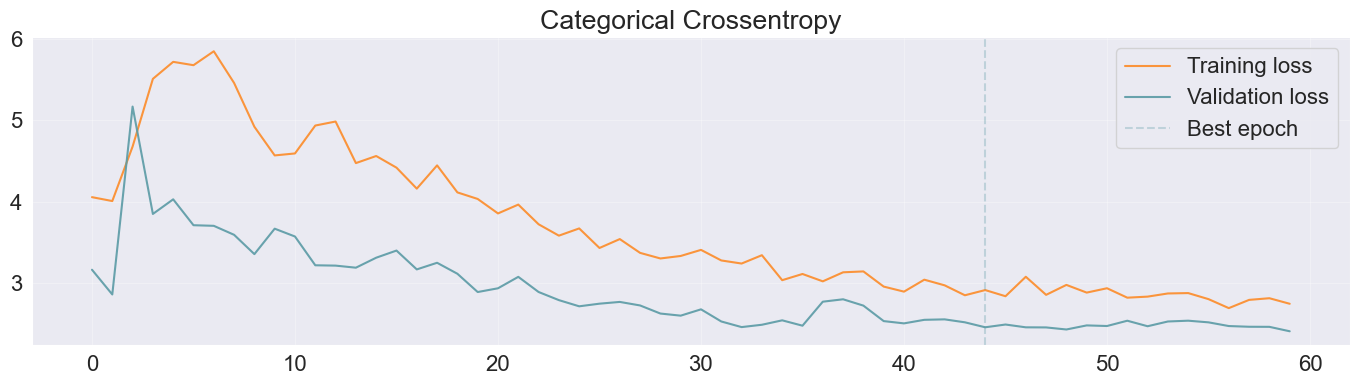

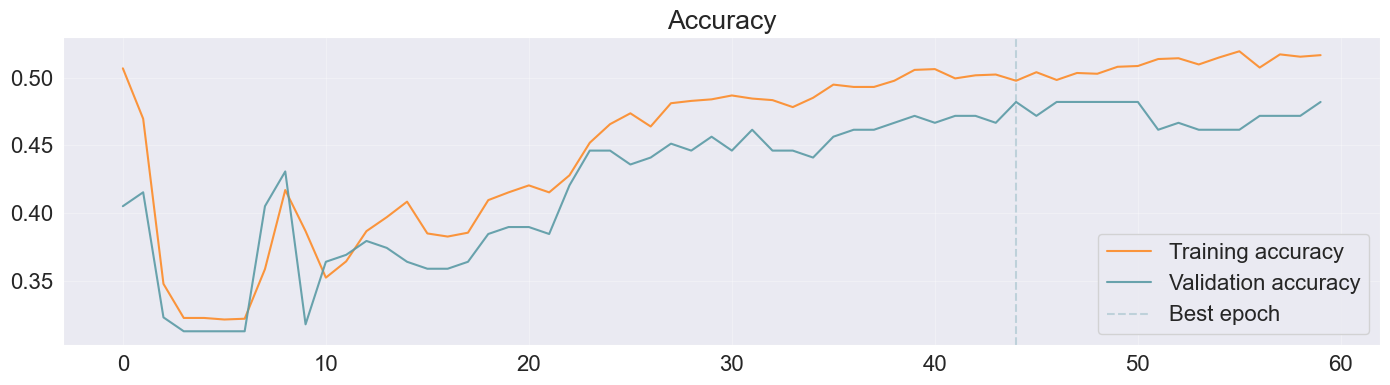

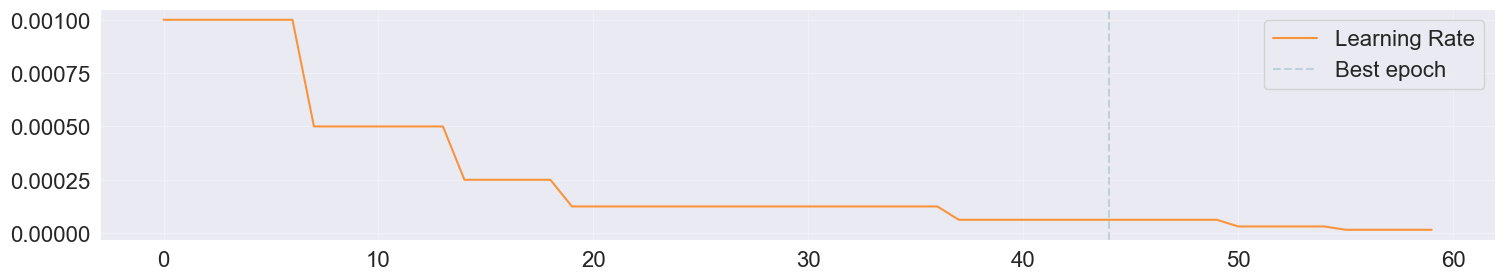

In [160]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()


plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

## Confusion Matrix

In [161]:
predictions = ensemble_model.predict(X_test)

 7/16 [============>.................] - ETA: 0s

2022-12-14 11:35:49.797108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 13ms/step


In [162]:
true_classes = y_test_classes

In [163]:
# Get most likely classes
predicted_classes = np.argmax(predictions, axis=-1)

Accuracy: 0.5
Precision: 0.227
Recall: 0.264
F1: 0.2259


/Users/matteopancini/miniconda/envs/mlenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


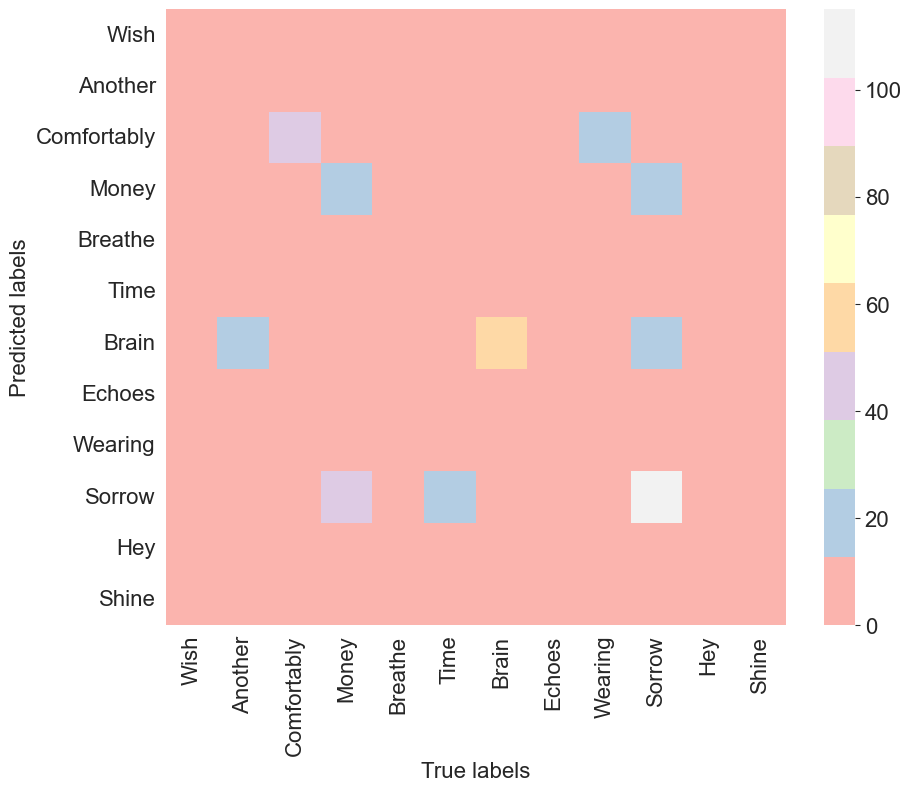

In [164]:
# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Compute the classification metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='macro')
recall = recall_score(true_classes, predicted_classes, average='macro')
f1 = f1_score(true_classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Pastel1', xticklabels=training_labels, yticklabels=training_labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## Save Model

In [165]:
#ensemble_model.save('Ensamble069')